In [19]:
import numpy as np
import pandas as pd
import csv
import math
from mt2 import mt2
import sys
sys.path.append("MLAnalysis")
from joblib import Parallel, delayed

import matplotlib.pyplot as plt

from MLAnalysis.Interfaces.LHCOlympics import LoadLHCOlympics
from MLAnalysis.CutAndExport.CutEvent import CutEvents
from MLAnalysis.CutAndExport.Histogram import *

from MLAnalysis.DataStructure.EventSet import *
from MLAnalysis.DataStructure.Particles import *

def mt(pt, etmiss, phi, etmiss_phi):
    # Calculate azimuthal angle difference
    delta_phi = np.abs(phi - etmiss_phi)
    if delta_phi > np.pi:
        delta_phi = 2 * np.pi - delta_phi

    # Calculate transverse mass
    mt = np.sqrt(2 * pt * etmiss * (1 - np.cos(delta_phi)))
    
    return mt


class AtLeastThreeLeps:

    def __init__(self,pt_max: float=50.0,met_max: float=50.0):
        self.pt_max = pt_max
        self.met_max = met_max

    def Cut(self, eventSample: EventSample) -> bool:
        lepCount = 0
        lepPT=[]
        p_met=LorentzVector(0, 0, 0, 0)
        p_lep=[]
        for p in eventSample.particles:
            if (ParticleType.Electron == p.particleType or ParticleType.Muon == p.particleType):
                lepCount = lepCount + 1
                lepPT.append(p.momentum.Pt())
                p_lep.append(p.momentum)

            if(ParticleType.Missing == p.particleType ):
                p_met=p.momentum

        MT=0.0
        pt_mt2=0.0
        lepPT2=np.sort(lepPT)[::-1]

        # if(len(lepPT)>2):
        #     idx= 2 #np.argmax(lepPT)
        #     pl= p_lep[idx].values 
        #     phi_l=math.atan2(pl[2],pl[1])

        #     phi_met=p_met.Azimuth()
        #     pt_met= p_met.Pt()

        #     MT=math.sqrt(2*lepPT[idx]* pt_met * (1.0-math.cos(phi_l-phi_met))) 


        # if(len(lepPT)>2):
        #     # print(lepPT)
        #     p_lep.sort(key=lambda item: item.Pt(), reverse=True)
        #     pl1=  p_lep[0].values
        #     pl2=  p_lep[1].values
        #     # print(pl1,pl2)
        #     pt_mt2= mt2(pl1[0],pl1[1],pl1[2],
        #         pl2[0],pl2[1],pl2[2],
        #         p_met.values[1], p_met.values[2],
        #         100.0,100.0)

        # return (lepCount < 3) or   lepPT2[2]<20 or lepPT2[0]<50 or lepPT2[1]<30 or  eventSample.GetETMissing() < 60
        return (lepCount < 3) or  eventSample.GetPTLepton()< self.pt_max or    eventSample.GetETMissing() < self.met_max


def get_pcd(ev,pt_max,met_max):
    events = LoadLHCOlympics(ev)
    # print(events)
    cut = AtLeastThreeLeps(pt_max,met_max)
    CutEvents(events, cut)
    pcd_list=[]
 
    for idx,event in enumerate(events.events):
        ps=event.particles
        met=[]
        met_et=event.GetETMissing()
        
        for p in ps:
            if ParticleStatus.Invisible == p.status:
                met=p.momentum
                phi_met=met.Azimuth()

        for p in ps:
            
            if (ParticleType.Electron == p.particleType or ParticleType.Muon == p.particleType):
                mom=p.momentum
                eta=mom.PseudoRapidity()
                phi=mom.Azimuth()
                pt=mom.Pt()
                R=mom.R()
                mt=np.sqrt(2*pt*met_et* (1.0-np.cos(phi_met -phi)))
                
                pcd_list.append([idx,eta,phi,R,pt,mt] + mom.values)
            
    return pd.DataFrame(pcd_list,columns=['event_no','eta','phi','R','pt','mt','E','px','py','pz'])

evs=[
"Events/nx-3lep-BP1.lhco",
"Events/nx-3lep-BP2.lhco",
"Events/zw-3l-1.lhco"
]

df1 = get_pcd(evs[0],50,150)
df2 = get_pcd(evs[1],50,150)
df = get_pcd(evs[2],50,150)

def pcd_divide(df,N):
    evs= df['event_no'].unique()
    ev_nbins= int(len(evs)/N)
    evt_lists= np.array_split(df['event_no'].unique(),ev_nbins)
    return [df[df['event_no'].isin(evt_list)] for evt_list in evt_lists]
    
xsections=[7.90,13.53,435.1]
kf=1.2
Ncut=[len(df.groupby('event_no')) for df in [df1,df2,df]]
N=[30000,50000,2000000]



In [20]:
import numpy as cp

def scale_it(df):
    def standard_scale_column(column):
        return (column - column.mean()) / column.std()
    
    return df.apply(standard_scale_column)

In [21]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, recall_score
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import matplotlib.pyplot as plt
from joblib import Parallel, delayed


from gtda.time_series import Resampler, SlidingWindow, takens_embedding_optimal_parameters, \
    TakensEmbedding, PermutationEntropy
from gtda.homology import WeakAlphaPersistence, VietorisRipsPersistence
from gtda.diagrams import Scaler, Filtering, PersistenceEntropy, BettiCurve, PairwiseDistance
from gtda.graphs import KNeighborsGraph, GraphGeodesicDistance
from gtda.diagrams import Amplitude


# from gtda.pipeline import Pipeline

import numpy as np
from sklearn.metrics import pairwise_distances


# WA=WeakAlphaPersistence(homology_dimensions=homology_dimensions)


def get_resampled_pcds(pcds,pcds1,pcds2):

    n_pcds=min([len(pcds1),len(pcds2),len(pcds)])
    BP1_pcds=[]
    BP2_pcds=[]
    SM_pcds=[]
        

    for idx in range(n_pcds):
        BP1=pcds1[idx][['eta', 'phi', 'R', 'pt', 'mt', 'E', 'px', 'py', 'pz']]
        BP2=pcds2[idx][['eta', 'phi', 'R', 'pt', 'mt', 'E', 'px', 'py', 'pz']]
        BG=pcds[idx][['eta', 'phi', 'R', 'pt', 'mt', 'E', 'px', 'py', 'pz']]

        BP_BG=pd.concat([BP1,BP2, BG], axis=0)

        label_BP1=np.ones(len(BP1))
        label_BP2=np.full(len(BP2),2)
        label_BG=np.zeros(len(BG))

        BP_BG_labels=np.vstack( (label_BP1[:,None],label_BP2[:,None],label_BG[:,None]))

        # smote = SMOTEENN(enn=EditedNearestNeighbours(n_neighbors=5))  #
        # smote=SMOTE(random_state=42,k_neighbors=5,sampling_strategy={1: 100,2:0.1})
        under = RandomUnderSampler()
        # steps = [('o', smote), ('u', under)]
        # pipeline = Pipeline(steps=steps)
        vectors1_res, labels1_res = under.fit_resample(BP_BG, BP_BG_labels)

        vectors1_res=vectors1_res.reset_index(drop=True)

        BG_res=vectors1_res.loc[np.where(labels1_res==0)[0]]
        BP1_res=vectors1_res.loc[np.where(labels1_res==1)[0]]
        BP2_res=vectors1_res.loc[np.where(labels1_res==2)[0]]


        # # smote = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='all',n_neighbors=5))  #
        # # smote=SMOTE(random_state=42,k_neighbors=3)

        # vectors2_res, labels2_res = under.fit_resample(BP2_BG, BP2_BG_labels)
        # vectors2_res=vectors2_res.reset_index(drop=True)

        # BG2_res=vectors2_res.loc[np.where(labels2_res==0)[0]]
        # BP2_res=vectors2_res.loc[np.where(labels2_res==1)[0]]

        BP1_pcds.append(BP1_res)
        BP2_pcds.append(BP2_res)
        SM_pcds.append(BG_res)
    
    return [BP1_pcds,
            BP2_pcds,
            SM_pcds]

lums=[50,100,150,200,300,400,500,600,700,800,900,1000]
ph_pcds_lums={}
scale=250

homology_dimensions = (0, 1, 2)
VR = VietorisRipsPersistence(homology_dimensions=homology_dimensions,max_edge_length=scale)

for lum in lums:

    print(f"Completed Lum: {lum}\n")
    
    Np=[int(lum*kf*x*Ncut[i]/N[i]) for i,x in enumerate(xsections)]
    pcds1=pcd_divide(df1,Np[0])
    pcds2=pcd_divide(df2,Np[1])
    pcds=pcd_divide(df,Np[2])
   
    n_pcds=min([len(pcds1),len(pcds2),len(pcds)])
    # BP1_pcds,BP2_pcds,SM_pcds=get_resampled_pcds(pcds,pcds1,pcds2)

    BP1_pcds=[]
    BP2_pcds=[]
    SM_pcds=[]
    for idx in range(n_pcds):
        # BP1_pcds.append(pcds1[idx][['px','py','pz']])
        # BP2_pcds.append(pcds2[idx][['px','py','pz']])
        # SM_pcds.append(pcds[idx][['px','py','pz']])

        BP1_pcds.append(pcds1[idx][['px','py','pz']])
        BP2_pcds.append(pcds2[idx][['px','py','pz']])
        SM_pcds.append(pcds[idx][['px','py','pz']])
    
    dg = VR.fit_transform(SM_pcds)
    dg1 = VR.fit_transform(BP1_pcds)
    dg2 = VR.fit_transform(BP2_pcds)

    ph_pcds_lums[lum]={
        'dg':dg,'dg1':dg1,'dg2':dg2,
    }
    

np.save('ph_pcds_lums_met150_scale250',ph_pcds_lums)
    
    # bc_dg= BC.fit_transform(dg)
    # bc_dg1= BC.fit_transform(dg1)
    # bc_dg2= BC.fit_transform(dg2)

    # A=AMP.fit_transform(dg)
    # A1=AMP.fit_transform(dg1)
    # A2=AMP.fit_transform(dg2)



Completed Lum: 50

Completed Lum: 100

Completed Lum: 150

Completed Lum: 200

Completed Lum: 300

Completed Lum: 400

Completed Lum: 500

Completed Lum: 600

Completed Lum: 700

Completed Lum: 800

Completed Lum: 900

Completed Lum: 1000



In [22]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, recall_score
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_fscore_support


def get_cl_scores(vector1,vector2,subset_size=None):

    if(subset_size):
        if(len(vector1) >=subset_size and len(vector2) >=subset_size ):
            indices1 = np.random.choice(len(vector1), size=subset_size, replace=False)
            vector1 = np.array(vector1)[indices1].reshape(-1, 1)

            indices2 = np.random.choice(len(vector2), size=subset_size, replace=False)
            vector2 = np.array(vector2)[indices2].reshape(-1, 1)
        
        else:
            vector1 = np.array(vector1).reshape(-1, 1)
            vector2 =np.array(vector2).reshape(-1, 1)

    else:
        vector1 = np.array(vector1).reshape(-1, 1)
        vector2 =np.array(vector2).reshape(-1, 1)
        
    vectors = np.vstack((vector1,  vector2))

    # Step 3: Labeling
    # Assuming we have labels for the vectors (e.g., class 0, class 1, class 2)
    labels = np.concatenate((np.zeros(len(vector1)), 
                             np.ones(len(vector2))))

    X_train0, X_test0, y_train0, y_test0 = train_test_split(vectors, labels , test_size=0.3, random_state=41)

    ## We will train the model using resampling so that the data is not skewed

    smote = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='all'))  #SMOTE(random_state=42,k_neighbors=5)
    vectors_res, labels_res = smote.fit_resample(vectors, labels)
    # X_train, X_test, y_train, y_test = train_test_split(vectors_res, labels_res , test_size=0.3, random_state=41)

    # Step 5: Feature Scaling (StandardScaler)
    scaler = StandardScaler()

    X_scaled = scaler.fit_transform(vectors_res)

    # this scaled X will be used for testing against actual data
    X_test0_scaled = scaler.transform(X_test0)

    # Choose a Model (Support Vector Machine)
    model = SVC(kernel='rbf', C=1.0, random_state=42)

    # https://scikit-learn.org/stable/modules/cross_validation.html
    scores = cross_val_score(model,X_scaled,labels_res, cv=10, scoring='accuracy',n_jobs=-1)
    # Print mean accuracy
    # print("Mean Accuracy:", np.mean(scores))

    y_pred = cross_val_predict(model,X_test0_scaled,y_test0, cv=10,n_jobs=-1)
    # Calculate precision, recall, and F1-score
    precision_cv, recall_cv, f1_score_cv, _ = precision_recall_fscore_support(y_test0, y_pred, average='weighted')

    # print("Cross-Validation Precision:", precision_cv)
    # print("Cross-Validation Recall:", recall_cv)
    # print("Cross-Validation F1 Score:", f1_score_cv)

    conf_matrix = confusion_matrix(y_true=y_test0, y_pred=y_pred)
    # Print the confusion matrix
    # print("Confusion Matrix:")
    # print(conf_matrix)
    return [np.mean(scores), precision_cv, recall_cv, f1_score_cv,conf_matrix ]



In [33]:
acc_lums=[]
ph_lums=[]

AMP=Amplitude(metric='wasserstein')
# AMP=Amplitude(metric='betti')
PE=PersistenceEntropy()

for lum in lums:

    BC = BettiCurve(n_bins=300)

    dg=ph_pcds_lums[lum]['dg']
    dg1=ph_pcds_lums[lum]['dg1']
    dg2=ph_pcds_lums[lum]['dg2']
    bc_dg= BC.fit_transform(dg)
    bc_dg1= BC.fit_transform(dg1)
    bc_dg2= BC.fit_transform(dg2)

    A_SM=AMP.fit_transform(dg)
    A_BP1=AMP.fit_transform(dg1)
    A_BP2=AMP.fit_transform(dg2)

    PE_SM=PE.fit_transform(dg)
    PE_BP1=PE.fit_transform(dg1)
    PE_BP2=PE.fit_transform(dg2)

    n_pcds=len(dg)


    for idx in range(n_pcds):
        a_sm=A_SM[idx].tolist()
        a_bp1=A_BP1[idx].tolist()
        a_bp2=A_BP2[idx].tolist()

        pe_sm=PE_SM[idx].tolist()
        pe_bp1=PE_BP1[idx].tolist()
        pe_bp2=PE_BP2[idx].tolist()

        ph_lums.append([lum,idx] + a_sm + a_bp1 + a_bp2 + pe_sm + pe_bp1 + pe_bp2)

    for idx in range(n_pcds):
        vector1 = bc_dg1[idx].T
        vector2 = bc_dg2[idx].T
        vector = bc_dg[idx].T
        acc_bp1=get_cl_scores(vector1,vector)
        acc_bp2=get_cl_scores(vector2,vector)

        acc_lums.append([lum,idx] + acc_bp1[:4]  + acc_bp2[:4])

df_acc_lums=pd.DataFrame(acc_lums,columns=['lum','pcd_id',
                                           'bp1_acc','bp1_pre','bp1_re','bp1_f1',
                                           'bp2_acc','bp2_pre','bp2_re','bp2_f1',
                                           ])

df_acc_lums

,lum,pcd_id,bp1_acc,bp1_pre,bp1_re,bp1_f1,bp2_acc,bp2_pre,bp2_re,bp2_f1
0,50,0,0.949384,0.544273,0.531481,0.406632,0.955622,0.540181,0.535185,0.443695
1,50,1,0.855202,0.619952,0.555556,0.510266,0.881744,0.515468,0.525926,0.443587
2,50,2,0.906638,0.550206,0.538889,0.448128,0.924605,0.644194,0.550000,0.430086
3,50,3,0.926646,0.501711,0.509259,0.494452,0.918690,0.469484,0.503704,0.425216
4,50,4,0.937113,0.624108,0.557407,0.511706,0.950800,0.511437,0.522222,0.474471
...,...,...,...,...,...,...,...,...,...,...
165,900,1,0.912360,0.495239,0.524074,0.380412,0.954478,0.488919,0.518519,0.409169
166,900,2,0.961924,0.486760,0.522222,0.385261,0.892155,0.432941,0.518519,0.371677
167,1000,0,0.949446,0.527820,0.533333,0.505502,0.977913,0.557417,0.531481,0.395775
168,1000,1,0.900085,0.516006,0.525926,0.457837,0.904896,0.545248,0.548148,0.541557


In [34]:
df_ph_lums=pd.DataFrame(ph_lums,columns=['lum','pcd_id',
                                           'a0_sm','a1_sm','a2_sm',
                                           'a0_bp1','a1_bp1','a2_bp1',
                                           'a0_bp2','a1_bp2','a2_bp2',
                                           'pe0_sm','pe1_sm','pe2_sm',
                                           'pe0_bp1','pe1_bp1','pe2_bp1',
                                           'pe0_bp2','pe1_bp2','pe2_bp2'
                                           ])

df_ph_lums

,lum,pcd_id,a0_sm,a1_sm,a2_sm,a0_bp1,a1_bp1,a2_bp1,a0_bp2,a1_bp2,a2_bp2,pe0_sm,pe1_sm,pe2_sm,pe0_bp1,pe1_bp1,pe2_bp1,pe0_bp2,pe1_bp2,pe2_bp2
0,50,0,370.077311,35.631150,1.479134,261.733167,11.291220,0.000000,312.951555,19.156686,0.000000,6.290326,4.090839,1.118590,4.982571,2.606687,-1.000000,5.166644,2.586037,-1.000000
1,50,1,480.477244,26.388447,0.000000,265.734807,17.203252,0.000000,326.184449,18.015386,1.608284,6.220424,3.795959,-1.000000,4.995424,2.168761,-1.000000,5.058158,3.130413,0.000000
2,50,2,395.848762,22.712020,0.104639,271.615605,15.458886,1.689552,349.076468,13.535561,0.177395,6.261551,4.626422,0.000000,4.994392,2.116406,0.000000,5.036284,2.526359,0.000000
3,50,3,459.768750,30.442618,1.727544,260.806783,7.498635,0.000000,349.074631,17.948469,0.000000,6.276763,3.905440,0.991900,4.796761,1.961843,-1.000000,5.142613,2.453256,-1.000000
4,50,4,461.332545,33.301690,1.146554,272.203299,9.752090,0.000000,299.822645,15.161452,0.000000,6.281164,4.596565,0.975606,4.834306,2.090484,-1.000000,4.955926,2.231825,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,900,1,957.019460,155.575294,29.190781,744.182848,91.976841,16.598387,686.729285,114.535376,18.442373,10.298763,9.128656,7.019311,9.167836,7.880997,5.434120,9.272623,7.896577,5.778125
166,900,2,957.406637,147.182275,34.330772,726.402452,98.570247,22.106223,784.041499,101.846099,15.024671,10.337312,9.151544,6.941440,9.167508,7.882494,5.546962,9.121268,7.901893,5.676019
167,1000,0,983.294376,155.562586,32.803925,654.455293,96.786379,13.859096,705.280542,101.971446,17.102562,10.767143,9.700893,7.698001,9.215732,7.782116,5.615557,9.196845,7.791462,5.620663
168,1000,1,1029.066000,165.860933,31.795365,744.182848,91.976841,16.598387,686.729285,114.535376,18.442373,10.712215,9.548295,7.403819,9.167836,7.880997,5.434120,9.272623,7.896577,5.778125


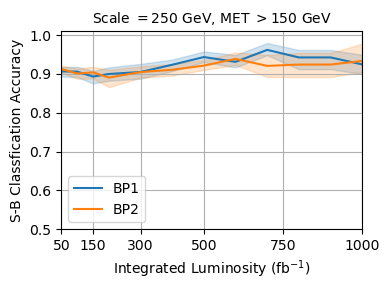

In [35]:
import seaborn as sns

plt.figure(figsize=(4, 3)) 

sns.lineplot(data=df_acc_lums, x="lum", y="bp1_acc",label="BP1")
sns.lineplot(data=df_acc_lums, x="lum", y="bp2_acc",label="BP2")
plt.grid(True)

plt.ylabel('S-B Classfication Accuracy')
plt.xlabel(r'Integrated Luminosity (fb$^{-1}$)')
plt.xticks(lums)

plt.xlim([50,1000])
plt.xticks([50,150,300,500,750,1000])
plt.ylim([0.5,1.01])
plt.title(r'Scale $=250$ GeV, MET $>150$ GeV', fontsize=10)
plt.tight_layout()

# Set custom ticks for the x-axis
plt.savefig(f'plots/acc_ph_met150_scale250_lums.pdf',bbox_inches='tight')


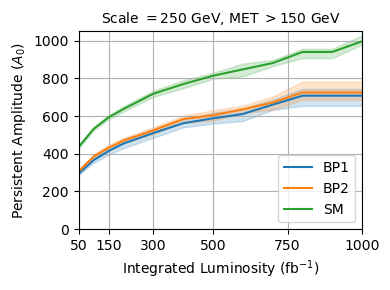

In [42]:
import seaborn as sns

plt.figure(figsize=(4, 3)) 

sns.lineplot(data=df_ph_lums, x="lum", y="a0_bp1",label="BP1")
sns.lineplot(data=df_ph_lums, x="lum", y="a0_bp2",label="BP2")
sns.lineplot(data=df_ph_lums, x="lum", y="a0_sm",label="SM")

plt.grid(True)

plt.ylabel(r'Persistent Amplitude ($A_0$)')
plt.xlabel(r'Integrated Luminosity (fb$^{-1}$)')
plt.xticks(lums)

plt.xlim([50,1000])
plt.xticks([50,150,300,500,750,1000])
plt.ylim([0,1050])
plt.title(r'Scale $=250$ GeV, MET $>150$ GeV', fontsize=10)
plt.tight_layout()

# Set custom ticks for the x-axis
plt.savefig(f'plots/pa0_met150_scale250_lums.pdf',bbox_inches='tight')


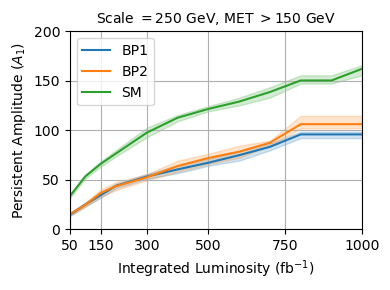

In [43]:
import seaborn as sns

plt.figure(figsize=(4, 3)) 

sns.lineplot(data=df_ph_lums, x="lum", y="a1_bp1",label="BP1")
sns.lineplot(data=df_ph_lums, x="lum", y="a1_bp2",label="BP2")
sns.lineplot(data=df_ph_lums, x="lum", y="a1_sm",label="SM")

plt.grid(True)

plt.ylabel(r'Persistent Amplitude ($A_1$)')
plt.xlabel(r'Integrated Luminosity (fb$^{-1}$)')
plt.xticks(lums)

plt.xlim([50,1000])
plt.xticks([50,150,300,500,750,1000])
plt.ylim([0,200])
plt.title(r'Scale $=250$ GeV, MET $>150$ GeV', fontsize=10)
plt.tight_layout()

# Set custom ticks for the x-axis
plt.savefig(f'plots/pa1_met150_scale250_lums.pdf',bbox_inches='tight')


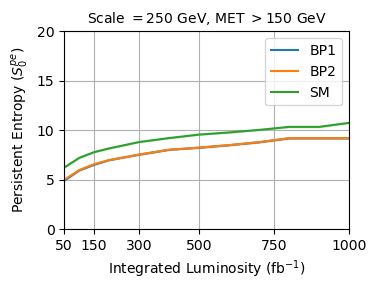

In [44]:
import seaborn as sns

plt.figure(figsize=(4, 3)) 

sns.lineplot(data=df_ph_lums, x="lum", y="pe0_bp1",label="BP1")
sns.lineplot(data=df_ph_lums, x="lum", y="pe0_bp2",label="BP2")
sns.lineplot(data=df_ph_lums, x="lum", y="pe0_sm",label="SM")

plt.grid(True)

plt.ylabel(r'Persistent Entropy ($S_0^{pe}$)')
plt.xlabel(r'Integrated Luminosity (fb$^{-1}$)')
plt.xticks(lums)

plt.xlim([50,1000])
plt.xticks([50,150,300,500,750,1000])
plt.ylim([0,20])
plt.title(r'Scale $=250$ GeV, MET $>150$ GeV', fontsize=10)
plt.tight_layout()

# Set custom ticks for the x-axis
plt.savefig(f'plots/pe0_met150_scale250_lums.pdf',bbox_inches='tight')




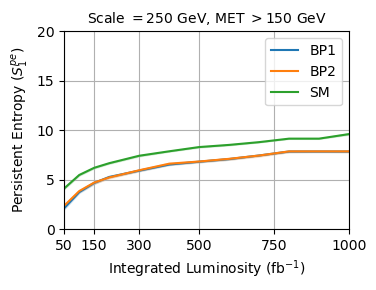

In [45]:
plt.figure(figsize=(4, 3)) 

sns.lineplot(data=df_ph_lums, x="lum", y="pe1_bp1",label="BP1")
sns.lineplot(data=df_ph_lums, x="lum", y="pe1_bp2",label="BP2")
sns.lineplot(data=df_ph_lums, x="lum", y="pe1_sm",label="SM")

plt.grid(True)

plt.ylabel(r'Persistent Entropy ($S_1^{pe}$)')
plt.xlabel(r'Integrated Luminosity (fb$^{-1}$)')
plt.xticks(lums)

plt.xlim([50,1000])
plt.xticks([50,150,300,500,750,1000])
plt.ylim([0,20])
plt.title(r'Scale $=250$ GeV, MET $>150$ GeV', fontsize=10)
plt.tight_layout()

# Set custom ticks for the x-axis
plt.savefig(f'plots/pe1_met150_scale250_lums.pdf',bbox_inches='tight')

In [40]:
df_ph_lums['r_a1_bp1']=df_ph_lums["a1_bp1"]/df_ph_lums["a1_sm"]
df_ph_lums['r_a1_bp2']=df_ph_lums["a1_bp2"]/df_ph_lums["a1_sm"]

df_ph_lums

,lum,pcd_id,a0_sm,a1_sm,a2_sm,a0_bp1,a1_bp1,a2_bp1,a0_bp2,a1_bp2,...,pe1_sm,pe2_sm,pe0_bp1,pe1_bp1,pe2_bp1,pe0_bp2,pe1_bp2,pe2_bp2,r_a1_bp1,r_a1_bp2
0,50,0,370.077311,35.631150,1.479134,261.733167,11.291220,0.000000,312.951555,19.156686,...,4.090839,1.118590,4.982571,2.606687,-1.000000,5.166644,2.586037,-1.000000,0.316892,0.537639
1,50,1,480.477244,26.388447,0.000000,265.734807,17.203252,0.000000,326.184449,18.015386,...,3.795959,-1.000000,4.995424,2.168761,-1.000000,5.058158,3.130413,0.000000,0.651924,0.682700
2,50,2,395.848762,22.712020,0.104639,271.615605,15.458886,1.689552,349.076468,13.535561,...,4.626422,0.000000,4.994392,2.116406,0.000000,5.036284,2.526359,0.000000,0.680648,0.595965
3,50,3,459.768750,30.442618,1.727544,260.806783,7.498635,0.000000,349.074631,17.948469,...,3.905440,0.991900,4.796761,1.961843,-1.000000,5.142613,2.453256,-1.000000,0.246320,0.589584
4,50,4,461.332545,33.301690,1.146554,272.203299,9.752090,0.000000,299.822645,15.161452,...,4.596565,0.975606,4.834306,2.090484,-1.000000,4.955926,2.231825,-1.000000,0.292841,0.455276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,900,1,957.019460,155.575294,29.190781,744.182848,91.976841,16.598387,686.729285,114.535376,...,9.128656,7.019311,9.167836,7.880997,5.434120,9.272623,7.896577,5.778125,0.591205,0.736205
166,900,2,957.406637,147.182275,34.330772,726.402452,98.570247,22.106223,784.041499,101.846099,...,9.151544,6.941440,9.167508,7.882494,5.546962,9.121268,7.901893,5.676019,0.669715,0.691973
167,1000,0,983.294376,155.562586,32.803925,654.455293,96.786379,13.859096,705.280542,101.971446,...,9.700893,7.698001,9.215732,7.782116,5.615557,9.196845,7.791462,5.620663,0.622170,0.655501
168,1000,1,1029.066000,165.860933,31.795365,744.182848,91.976841,16.598387,686.729285,114.535376,...,9.548295,7.403819,9.167836,7.880997,5.434120,9.272623,7.896577,5.778125,0.554542,0.690551


<Axes: xlabel='lum', ylabel='r_a1_bp1'>

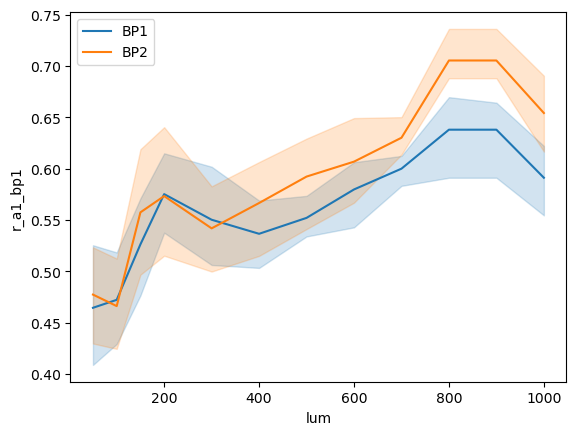

In [41]:
sns.lineplot(data=df_ph_lums, x="lum", y="r_a1_bp1",label="BP1")
sns.lineplot(data=df_ph_lums, x="lum", y="r_a1_bp2",label="BP2")